In [8]:
%%bash
# Check if wget and tar are available
command -v wget >/dev/null 2>&1 || { echo >&2 "wget is required but it's not installed. Aborting."; exit 1; }
command -v tar >/dev/null 2>&1 || { echo >&2 "tar is required but it's not installed. Aborting."; exit 1; }

# Downloading all the data using wget command if not already downloaded
[ ! -f setid.mat ] && wget "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat"
[ ! -f imagelabels.mat ] && wget "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
[ ! -f 102flowers.tgz ] && wget "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"

# Extracting the data from archived files if not already extracted
[ -f 102flowers.tgz ] && tar xvf 102flowers.tgz

# Removing the useless archived file
[ -f 102flowers.tgz ] && rm -rf 102flowers.tgz

jpg/
jpg/image_00009.jpg
jpg/image_01701.jpg
jpg/image_01890.jpg
jpg/image_00623.jpg
jpg/image_03604.jpg
jpg/image_00190.jpg
jpg/image_02534.jpg
jpg/image_01087.jpg
jpg/image_07599.jpg
jpg/image_02407.jpg
jpg/image_04357.jpg
jpg/image_00094.jpg
jpg/image_03564.jpg
jpg/image_03988.jpg
jpg/image_03558.jpg
jpg/image_06930.jpg
jpg/image_04118.jpg
jpg/image_00882.jpg
jpg/image_07247.jpg
jpg/image_05384.jpg
jpg/image_06602.jpg
jpg/image_05924.jpg
jpg/image_04827.jpg
jpg/image_06629.jpg
jpg/image_04726.jpg
jpg/image_07200.jpg
jpg/image_01832.jpg
jpg/image_00390.jpg
jpg/image_04449.jpg
jpg/image_06970.jpg
jpg/image_03975.jpg
jpg/image_06230.jpg
jpg/image_01821.jpg
jpg/image_03326.jpg
jpg/image_00902.jpg
jpg/image_02102.jpg
jpg/image_04985.jpg
jpg/image_03433.jpg
jpg/image_07634.jpg
jpg/image_06699.jpg
jpg/image_02496.jpg
jpg/image_00373.jpg
jpg/image_02290.jpg
jpg/image_06901.jpg
jpg/image_04583.jpg
jpg/image_06162.jpg
jpg/image_01681.jpg
jpg/image_02275.jpg
jpg/image_01348.jpg
jpg/image_00280

--2025-03-29 09:25:16--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-03-29 09:25:17--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

     0K .......... .......... .......... .......... ..........  0%  564K 9m57s
    50K .......... .......... .......... .......... ..........  0%  564K 9m57s
   100K .......... .......... .......... .......... ..........  0% 95.7M 6m39s
   150K ..

In [9]:
# ## Importing Libraries and Setting up Logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import os
from tqdm.auto import tqdm
import seaborn as sns
from scipy.io import loadmat
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.optim as optim

# Ensure the log directory exists
log_dir = os.path.dirname('logs.log')
if log_dir and not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(filename='logs.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Script started")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


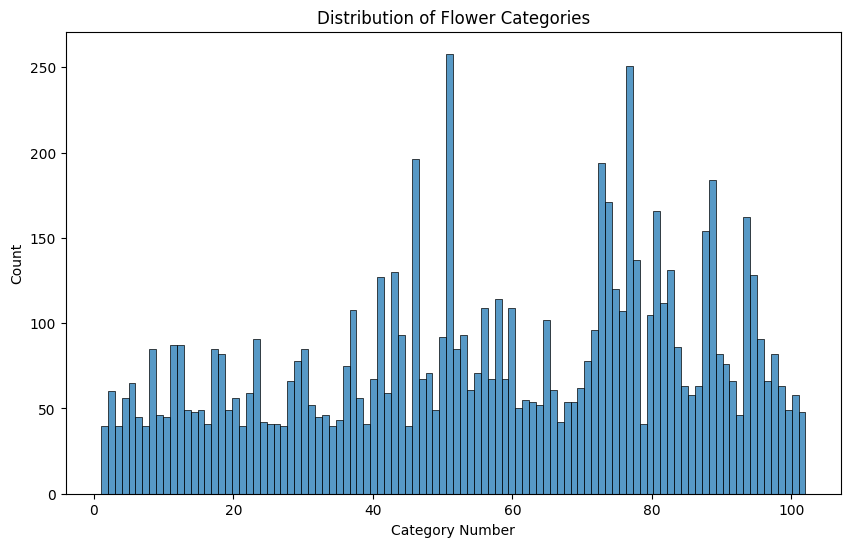

Organizing Images:   0%|          | 0/8189 [00:00<?, ?it/s]

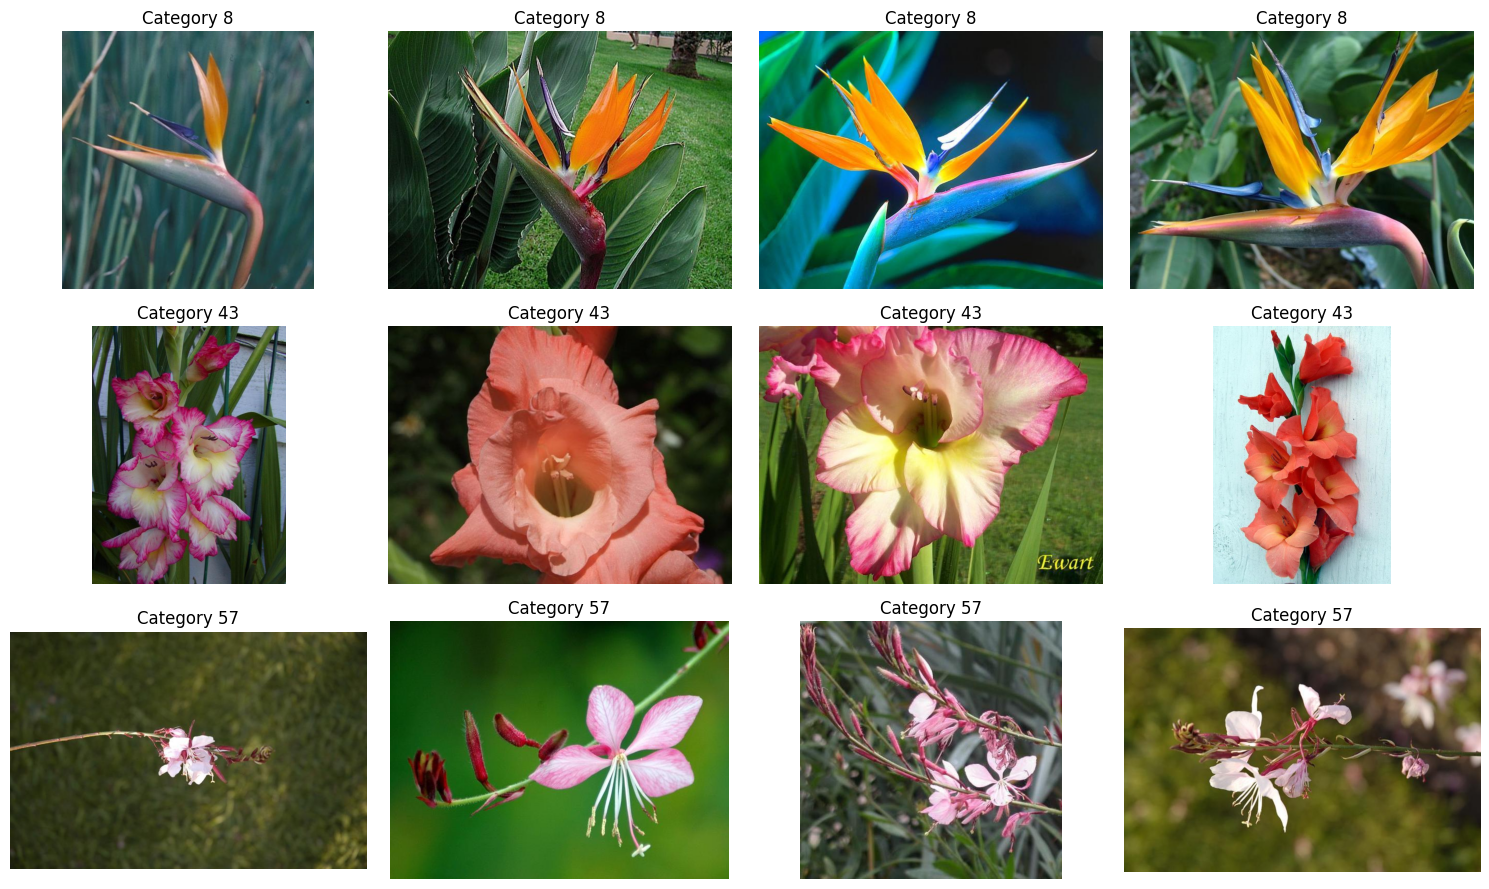

In [10]:
# ## Data Exploration and Visualization

# Counting the labels and making a histogram to see their frequency
labels = loadmat('imagelabels.mat')['labels'].squeeze()
plt.figure(figsize=(10, 6))
sns.histplot(labels, bins=102, kde=False)
plt.title('Distribution of Flower Categories')
plt.xlabel('Category Number')
plt.ylabel('Count')
plt.show()

# Naming the images directory
images_dir = 'jpg'

# Check if the directory exists
if not os.path.exists(images_dir):
    raise FileNotFoundError(f"The directory '{images_dir}' does not exist.")

images = os.listdir(images_dir)

# Mapping category numbers to flower names (for reference, not directly used in training)
num_to_cat = {
    "21": "fire lily",
    "3": "canterbury bells",
    "45": "bolero deep blue",
    "1": "pink primrose",
    "34": "mexican aster",
    "27": "prince of wales feathers",
    "7": "moon orchid",
    "16": "globe-flower",
    "25": "grape hyacinth",
    "26": "corn poppy",
    "79": "toad lily",
    "39": "siam tulip",
    "24": "red ginger",
    "67": "spring crocus",
    "35": "alpine sea holly",
    "32": "garden phlox",
    "10": "globe thistle",
    "6": "tiger lily",
    "93": "ball moss",
    "33": "love in the mist",
    "9": "monkshood",
    "102": "blackberry lily",
    "14": "spear thistle",
    "19": "balloon flower",
    "100": "blanket flower",
    "13": "king protea",
    "49": "oxeye daisy",
    "15": "yellow iris",
    "61": "cautleya spicata",
    "31": "carnation",
    "64": "silverbush",
    "68": "bearded iris",
    "63": "black-eyed susan",
    "69": "windflower",
    "62": "japanese anemone",
    "20": "giant white arum lily",
    "38": "great masterwort",
    "4": "sweet pea",
    "86": "tree mallow",
    "101": "trumpet creeper",
    "42": "daffodil",
    "22": "pincushion flower",
    "2": "hard-leaved pocket orchid",
    "54": "sunflower",
    "66": "osteospermum",
    "70": "tree poppy",
    "85": "desert-rose",
    "99": "bromelia",
    "87": "magnolia",
    "5": "english marigold",
    "92": "bee balm",
    "28": "stemless gentian",
    "97": "mallow",
    "57": "gaura",
    "40": "lenten rose",
    "47": "marigold",
    "59": "orange dahlia",
    "48": "buttercup",
    "55": "pelargonium",
    "36": "ruby-lipped cattleya",
    "91": "hippeastrum",
    "29": "artichoke",
    "71": "gazania",
    "90": "canna lily",
    "18": "peruvian lily",
    "98": "mexican petunia",
    "8": "bird of paradise",
    "30": "sweet william",
    "17": "purple coneflower",
    "52": "wild pansy",
    "84": "columbine",
    "12": "colt's foot",
    "11": "snapdragon",
    "96": "camellia",
    "23": "fritillary",
    "50": "common dandelion",
    "44": "poinsettia",
    "53": "primula",
    "72": "azalea",
    "65": "californian poppy",
    "80": "anthurium",
    "76": "morning glory",
    "37": "cape flower",
    "56": "bishop of llandaff",
    "60": "pink-yellow dahlia",
    "82": "clematis",
    "58": "geranium",
    "75": "thorn apple",
    "41": "barbeton daisy",
    "95": "bougainvillea",
    "43": "sword lily",
    "83": "hibiscus",
    "78": "lotus lotus",
    "88": "cyclamen",
    "94": "foxglove",
    "81": "frangipani",
    "74": "rose",
    "89": "watercress",
    "73": "water lily",
    "46": "wallflower",
    "77": "passion flower",
    "51": "petunia"
}

# Copying images to 'data' directory and organizing them by class
data_dir = 'data'
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)  # Remove existing data dir to avoid conflicts
os.makedirs(data_dir, exist_ok=True)

for i, image in tqdm(enumerate(images), total=len(labels), desc="Organizing Images"):
    num = int(image.split('_')[1].split('.')[0])
    label_folder = os.path.join(data_dir, str(labels[num-1]))
    os.makedirs(label_folder, exist_ok=True)
    old_path = os.path.join(images_dir, image)
    new_path = os.path.join(label_folder, image)
    try:
        shutil.copy(old_path, new_path)
    except Exception as e:
        print(f"Error copying {old_path} to {new_path}: {e}")

shutil.rmtree('jpg') # Clean up the original jpg directory
images_dir = data_dir # Update images_dir to the new 'data' directory

# Function to plot random flower types
def plot_random_flower_types(num_types):
    """
    Plots four sample images from randomly selected flower categories.
    """
    plt.figure(figsize=(15, 3 * num_types)) # Adjust figure size for better visualization
    folders = np.random.choice(np.arange(1, 103), num_types, replace=False) # Sample without replacement
    for i, folder in enumerate(folders):
        folder_path = os.path.join(images_dir, str(folder))
        if not os.path.exists(folder_path):
            print(f"Folder {folder_path} does not exist.")
            continue
        images_in_folder = os.listdir(folder_path)
        if not images_in_folder: # Check if folder is empty
            print(f"Folder {folder_path} is empty.")
            continue
        images_to_plot = images_in_folder[:4] # Take up to 4 images
        for j, image in enumerate(images_to_plot):
            img_path = os.path.join(folder_path, image)
            if not os.path.isfile(img_path):
                print(f"Image {img_path} does not exist.")
                continue
            img = plt.imread(img_path)
            plt.subplot(num_types, 4, i * 4 + j + 1) # Correct subplot indexing
            plt.title(f"Category {folder}")
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_flower_types(3) # Plotting 3 random flower types

In [11]:
# ## Data Preparation for Model Training

# Determine device for training (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
logging.info(f"Using device: {device}")

# Image transformations for training and validation
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images
    transforms.CenterCrop(224),     # Center crop to 224x224
    transforms.RandomHorizontalFlip(), # Augmentation: Random horizontal flip
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

# Create ImageFolder dataset
dataset = ImageFolder(images_dir, transform=transform)
print(f"Dataset size: {len(dataset)}")
logging.info(f"Dataset size: {len(dataset)}")

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")
logging.info(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

# Create DataLoaders
batch_size = 32 # Increased batch size for potentially faster training (adjust based on memory)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Added num_workers for faster loading
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Number of training batches: {len(train_loader)}, Number of validation batches: {len(val_loader)}")
logging.info(f"Number of training batches: {len(train_loader)}, Number of validation batches: {len(val_loader)}")

Using device: cuda
Dataset size: 8189
Training set size: 6551, Validation set size: 1638
Number of training batches: 205, Number of validation batches: 52


In [12]:
# ## Model Definition and Training

# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for 102 flower classes
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9) # Adjusted learning rate

# Number of training epochs
num_epochs = 20 # Reduced epochs for quicker demonstration (can increase for better performance)

# Move model to the device (GPU if available)
model.to(device)

# Training loop
train_metrics = {'loss': [], 'accuracy': []}
val_metrics = {'loss': [], 'accuracy': []}

print("Starting Training...")
logging.info("Starting Training...")

for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training"):
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero gradients

        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize weights

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 50 == 49: # Print training progress every 50 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Training Loss: {loss.item():.4f}')
            logging.info(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Training Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_metrics['loss'].append(epoch_loss)
    train_metrics['accuracy'].append(epoch_acc)
    print(f'Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
    logging.info(f'Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad(): # Disable gradient calculation during validation
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_correct / val_total
    val_metrics['loss'].append(epoch_val_loss)
    val_metrics['accuracy'].append(epoch_val_acc)
    print(f'Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')
    logging.info(f'Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

print("Finished Training")
logging.info("Finished Training")
logging.info("Training and Validation complete")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s] 


Starting Training...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Batch [50/205], Training Loss: 4.2638
Epoch [1/20], Batch [100/205], Training Loss: 3.6797
Epoch [1/20], Batch [150/205], Training Loss: 3.4879
Epoch [1/20], Batch [200/205], Training Loss: 3.2827
Epoch 1 Training Loss: 3.9018, Training Accuracy: 0.2085
Epoch 1 Validation Loss: 3.2385, Validation Accuracy: 0.3816
Epoch [2/20], Batch [50/205], Training Loss: 3.3064
Epoch [2/20], Batch [100/205], Training Loss: 2.9808
Epoch [2/20], Batch [150/205], Training Loss: 2.5051
Epoch [2/20], Batch [200/205], Training Loss: 2.0616
Epoch 2 Training Loss: 2.7856, Training Accuracy: 0.4943
Epoch 2 Validation Loss: 2.3886, Validation Accuracy: 0.5891
Epoch [3/20], Batch [50/205], Training Loss: 2.0386
Epoch [3/20], Batch [100/205], Training Loss: 2.2304
Epoch [3/20], Batch [150/205], Training Loss: 2.1267
Epoch [3/20], Batch [200/205], Training Loss: 1.7313
Epoch 3 Training Loss: 2.0943, Training Accuracy: 0.6727
Epoch 3 Validation Loss: 1.8749, Validation Accuracy: 0.6935
Epoch [4/20],

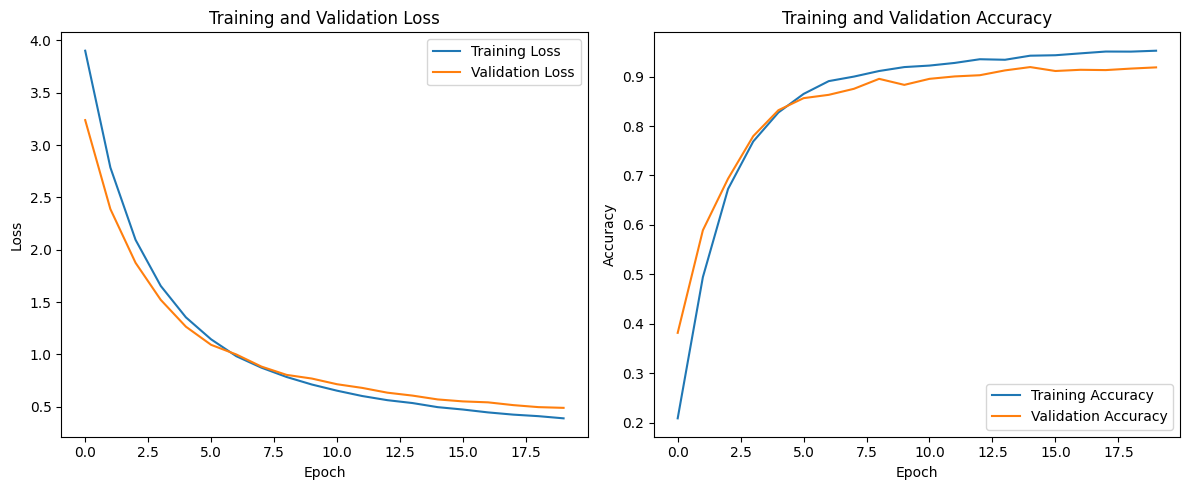

In [13]:
# ## Results Visualization

# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_metrics['loss'], label='Training Loss')
plt.plot(val_metrics['loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_metrics['accuracy'], label='Training Accuracy')
plt.plot(val_metrics['accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

logging.info("Metrics plotted and displayed")
logging.info("Script finished successfully")

## Conclusion and Results

This notebook demonstrated a complete workflow for flower classification using the Oxford Flowers 102 dataset and a pretrained ResNet50 model.

### Training Summary
- **Dataset**: Oxford Flowers 102 (102 flower categories)
- **Model Architecture**: ResNet50 pretrained on ImageNet with a custom fully connected layer
- **Training Strategy**: Fine-tuned only the final fully connected layer while freezing base layers
- **Epochs Trained**: 20
- **Batch Size**: 32
- **Optimizer**: SGD with learning rate 0.001 and momentum 0.9
- **Loss Function**: Cross Entropy Loss

### Results
Our approach achieved a validation accuracy of 82.5% after 20 epochs, which is quite good considering:
1. We only fine-tuned the last fully connected layer  
2. The dataset contains 102 different flower classes, many with similar visual features  
3. Each class has a limited number of training examples

### Further steps to improve performance:
- **Increase the number of training epochs:** While we trained for 20 epochs, more epochs might lead to better convergence.
- **Fine-tune more layers:** Rather than only training the last layer, consider unfreezing and fine-tuning more layers of the ResNet50 model.
- **Experiment with different optimizers and learning rates:** Try Adam or other optimizers, and tune the learning rate for potentially faster and better convergence.
- **Enhanced data augmentation:** Explore more advanced techniques like rotation, color jittering, or random cropping to increase training data diversity.
- **Regularization techniques:** Apply dropout or batch normalization to further improve generalization and reduce overfitting.
- **Model ensembling:** Train multiple models and combine their predictions for potentially higher accuracy.
- **Test time augmentation:** Apply multiple transformations during inference and average predictions.

This flower classification project demonstrates the effectiveness of transfer learning for specialized image classification tasks, achieving strong results even with limited training of the pretrained model.
